In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, fbeta_score, matthews_corrcoef, log_loss,
                             confusion_matrix, classification_report, make_scorer,
                             balanced_accuracy_score, accuracy_score, roc_curve,
                             auc, recall_score, roc_auc_score, average_precision_score,
                             precision_score, 
                             precision_recall_curve, multilabel_confusion_matrix)




In [2]:
data=pd.read_csv("predictive_maintenance.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [5]:
data["Failure Type"]

0       No Failure
1       No Failure
2       No Failure
3       No Failure
4       No Failure
           ...    
9995    No Failure
9996    No Failure
9997    No Failure
9998    No Failure
9999    No Failure
Name: Failure Type, Length: 10000, dtype: object

In [6]:
data["Failure Type"].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [7]:
from sklearn.preprocessing import LabelBinarizer
labelbinarizer = LabelBinarizer()
encoded_results_1 = labelbinarizer.fit_transform(data["Failure Type"])
encoded_results_1

array([[0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [8]:
df_encoded_1 = pd.DataFrame(encoded_results_1,columns=labelbinarizer.classes_)
df_encoded_1

,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
9995,0,1,0,0,0,0
9996,0,1,0,0,0,0
9997,0,1,0,0,0,0
9998,0,1,0,0,0,0


In [9]:
data["Type"].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [10]:
encoded_results_2 = labelbinarizer.fit_transform(data["Type"])
encoded_results_2

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [11]:
df_encoded_2 = pd.DataFrame(encoded_results_2,columns=labelbinarizer.classes_)
df_encoded_2

,H,L,M
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
9995,0,0,1
9996,1,0,0
9997,0,0,1
9998,1,0,0


In [12]:
data1 = pd.concat([data, df_encoded_1, df_encoded_2], axis=1)
data1.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure,H,L,M
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,0,1,0,0,0,0,0,0,1
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,0,1,0,0,0,0,0,1,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,0,1,0,0,0,0,0,1,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,0,1,0,0,0,0,0,1,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,0,1,0,0,0,0,0,1,0


In [13]:
data1.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type', 'Heat Dissipation Failure',
       'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures',
       'Tool Wear Failure', 'H', 'L', 'M'],
      dtype='object')

In [14]:
data1 = data1.drop(['Product ID', 'UDI', 'Type', 'Failure Type'], axis=1)
data1.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure,H,L,M
0,298.1,308.6,1551,42.8,0,0,0,1,0,0,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,1,0,0,0,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,1,0,0,0,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,1,0,0,0,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,1,0,0,0,0,0,1,0


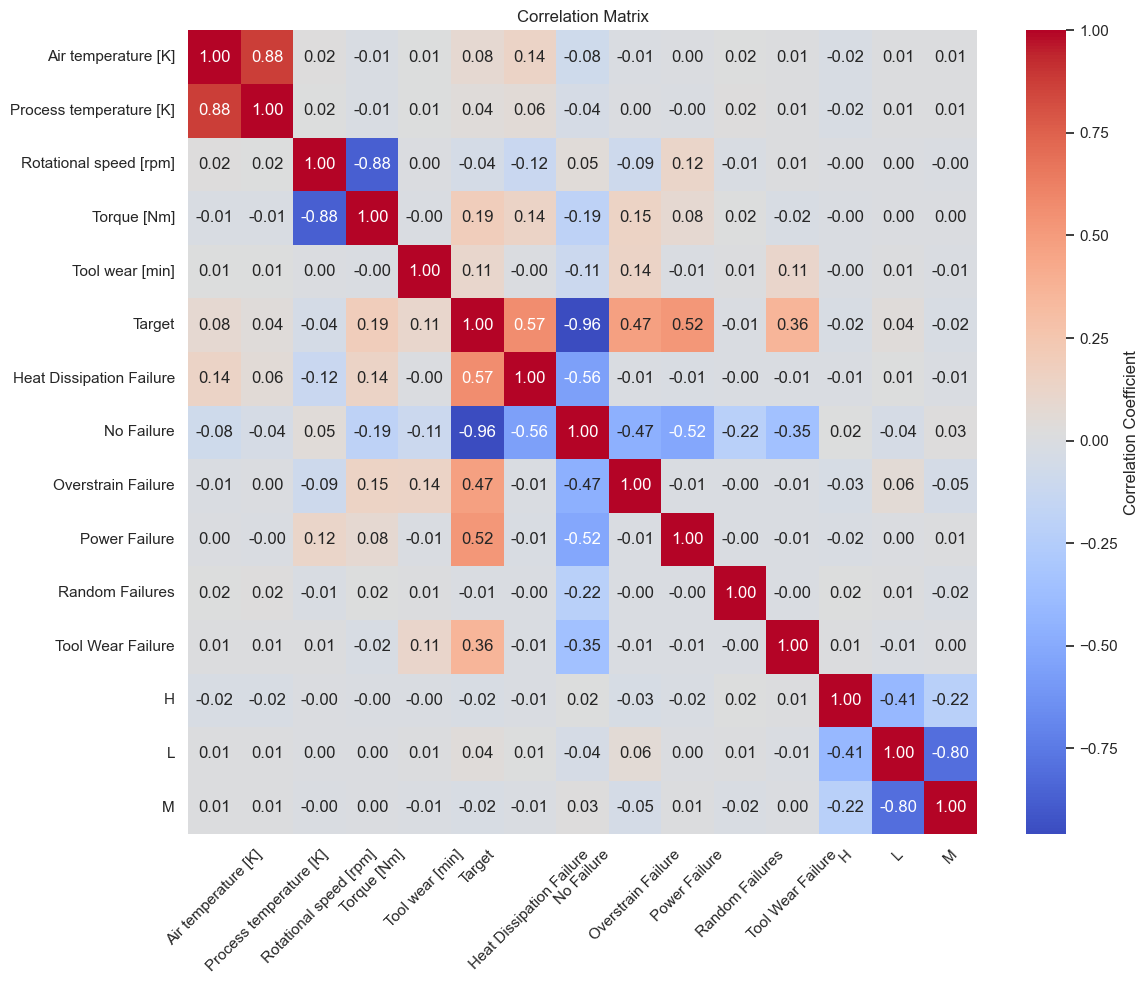

In [15]:
figure = plt.figure(figsize=(12, 10))
sns.heatmap(data1.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation Coefficient'})
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [16]:
data1.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure', 'H', 'L', 'M'],
      dtype='object')

In [17]:
column_order = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                'Torque [Nm]', 'Tool wear [min]', 'H', 'L', 'M', 'Target', 
                'No Failure', 'Heat Dissipation Failure', 'Overstrain Failure', 
                'Power Failure', 'Tool Wear Failure', 'Random Failures']

data1 = data1.reindex(columns=column_order)


In [18]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Air temperature [K]       10000 non-null  float64
 1   Process temperature [K]   10000 non-null  float64
 2   Rotational speed [rpm]    10000 non-null  int64  
 3   Torque [Nm]               10000 non-null  float64
 4   Tool wear [min]           10000 non-null  int64  
 5   H                         10000 non-null  int32  
 6   L                         10000 non-null  int32  
 7   M                         10000 non-null  int32  
 8   Target                    10000 non-null  int64  
 9   No Failure                10000 non-null  int32  
 10  Heat Dissipation Failure  10000 non-null  int32  
 11  Overstrain Failure        10000 non-null  int32  
 12  Power Failure             10000 non-null  int32  
 13  Tool Wear Failure         10000 non-null  int32  
 14  Random 

In [19]:
data1 = data1.reindex(columns=[
    'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
    'Torque [Nm]', 'Tool wear [min]', 'H', 'L', 'M', 'Target', 
    'No Failure', 'Heat Dissipation Failure', 'Overstrain Failure', 
    'Power Failure', 'Tool Wear Failure', 'Random Failures'
])
data1

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],H,L,M,Target,No Failure,Heat Dissipation Failure,Overstrain Failure,Power Failure,Tool Wear Failure,Random Failures
0,298.1,308.6,1551,42.8,0,0,0,1,0,1,0,0,0,0,0
1,298.2,308.7,1408,46.3,3,0,1,0,0,1,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,1,0,0,1,0,0,0,0,0
3,298.2,308.6,1433,39.5,7,0,1,0,0,1,0,0,0,0,0
4,298.2,308.7,1408,40.0,9,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,1,0,1,0,0,0,0,0
9996,298.9,308.4,1632,31.8,17,1,0,0,0,1,0,0,0,0,0
9997,299.0,308.6,1645,33.4,22,0,0,1,0,1,0,0,0,0,0
9998,299.0,308.7,1408,48.5,25,1,0,0,0,1,0,0,0,0,0


In [20]:
data1.columns=data1.columns.astype("str")
data1

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],H,L,M,Target,No Failure,Heat Dissipation Failure,Overstrain Failure,Power Failure,Tool Wear Failure,Random Failures
0,298.1,308.6,1551,42.8,0,0,0,1,0,1,0,0,0,0,0
1,298.2,308.7,1408,46.3,3,0,1,0,0,1,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,1,0,0,1,0,0,0,0,0
3,298.2,308.6,1433,39.5,7,0,1,0,0,1,0,0,0,0,0
4,298.2,308.7,1408,40.0,9,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,1,0,1,0,0,0,0,0
9996,298.9,308.4,1632,31.8,17,1,0,0,0,1,0,0,0,0,0
9997,299.0,308.6,1645,33.4,22,0,0,1,0,1,0,0,0,0,0
9998,299.0,308.7,1408,48.5,25,1,0,0,0,1,0,0,0,0,0


In [21]:
X = data1.iloc[:, 0:8].values.astype("float")
y = data1.iloc[:, 8:].values.astype("uint8")


In [22]:
X.shape

(10000, 8)

In [23]:
y.shape

(10000, 7)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.33)


In [25]:
scaler = StandardScaler().fit(x_test)
lgbm = LGBMClassifier()


In [26]:
from sklearn.multioutput import ClassifierChain


In [27]:
model_lgb = MultiOutputClassifier(estimator=lgbm,n_jobs=None)
chain_lgbm = ClassifierChain(lgbm, order='random', random_state=0)
model_lgb_pred = chain_lgbm.fit(x_train, y_train)
print(model_lgb_pred.score(x_test,y_test)*100)


[LightGBM] [Info] Number of positive: 12, number of negative: 6688
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 6700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001791 -> initscore=-6.323164
[LightGBM] [Info] Start training from score -6.323164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 30, number of negative: 6670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 6700, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004478 -> initscore=-5.404178
[LightGBM] [Info] Start training from score -5.404178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [28]:
yhat_lgb = model_lgb_pred.predict(x_test)
yhat_lgb

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [29]:
yhat_lgb[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
y_test[:,0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [31]:


print("F1 Score:", f1_score(y_test[:,0], yhat_lgb[:,0]) * 100)
print("F-beta Score:", fbeta_score(y_test[:,0], yhat_lgb[:,0], beta=2) * 100)
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Log Loss:", log_loss(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Confusion Matrix:\n", confusion_matrix(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Classification Report:\n", classification_report(y_test[:,0], yhat_lgb[:,0]))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Accuracy Score:", accuracy_score(y_test[:,0], yhat_lgb[:,0]) * 100)
print("ROC AUC Score:", roc_auc_score(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Average Precision Score:", average_precision_score(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Precision Score:", precision_score(y_test[:,0], yhat_lgb[:,0]) * 100)
print("Multilabel Confusion Matrix:\n", multilabel_confusion_matrix(y_test[:,0], yhat_lgb[:,0]) * 100)


F1 Score: 73.62637362637363
F-beta Score: 67.81376518218623
Matthews Correlation Coefficient: 73.69279202392312
Log Loss: 52.42713220235225
Confusion Matrix:
 [[318500   1100]
 [  3700   6700]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3196
           1       0.86      0.64      0.74       104

    accuracy                           0.99      3300
   macro avg       0.92      0.82      0.86      3300
weighted avg       0.98      0.99      0.98      3300

Balanced Accuracy Score: 82.03944834889766
Accuracy Score: 98.54545454545455
ROC AUC Score: 82.03944834889766
Average Precision Score: 56.45898332436794
Precision Score: 85.8974358974359
Multilabel Confusion Matrix:
 [[[  6700   3700]
  [  1100 318500]]

 [[318500   1100]
  [  3700   6700]]]


Classification Report for column 0:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3196
           1       0.86      0.64      0.74       104

    accuracy                           0.99      3300
   macro avg       0.92      0.82      0.86      3300
weighted avg       0.98      0.99      0.98      3300



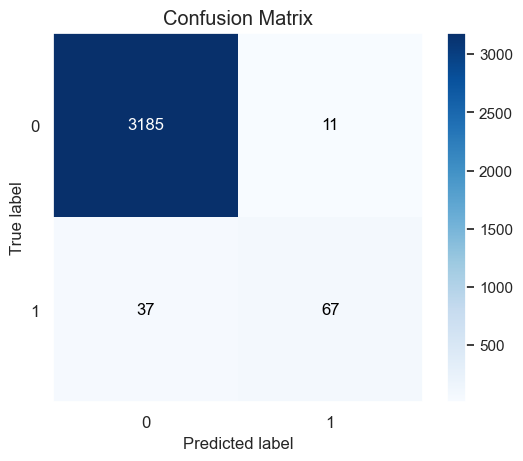

Classification Report for column 1:
               precision    recall  f1-score   support

           0       0.86      0.63      0.73       106
           1       0.99      1.00      0.99      3194

    accuracy                           0.98      3300
   macro avg       0.92      0.81      0.86      3300
weighted avg       0.98      0.98      0.98      3300



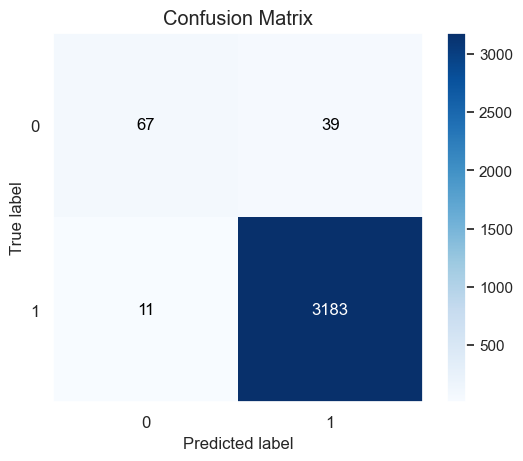

Classification Report for column 2:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3266
           1       0.83      0.85      0.84        34

    accuracy                           1.00      3300
   macro avg       0.91      0.93      0.92      3300
weighted avg       1.00      1.00      1.00      3300



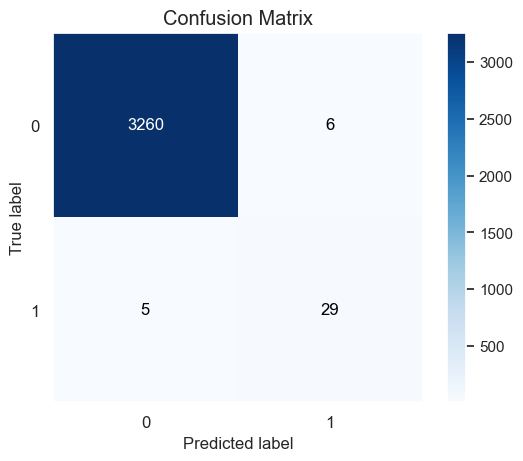

Classification Report for column 3:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3274
           1       0.70      0.62      0.65        26

    accuracy                           0.99      3300
   macro avg       0.85      0.81      0.83      3300
weighted avg       0.99      0.99      0.99      3300



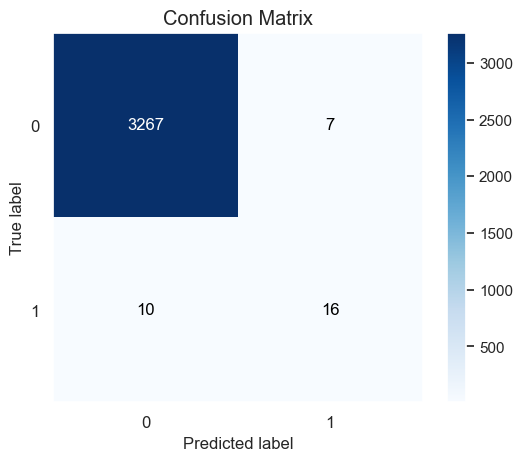

Classification Report for column 4:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3275
           1       0.82      0.56      0.67        25

    accuracy                           1.00      3300
   macro avg       0.91      0.78      0.83      3300
weighted avg       1.00      1.00      1.00      3300



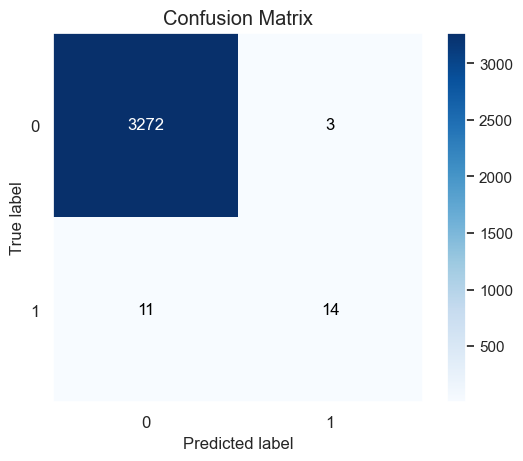

Classification Report for column 5:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3285
           1       0.00      0.00      0.00        15

    accuracy                           0.99      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       0.99      0.99      0.99      3300



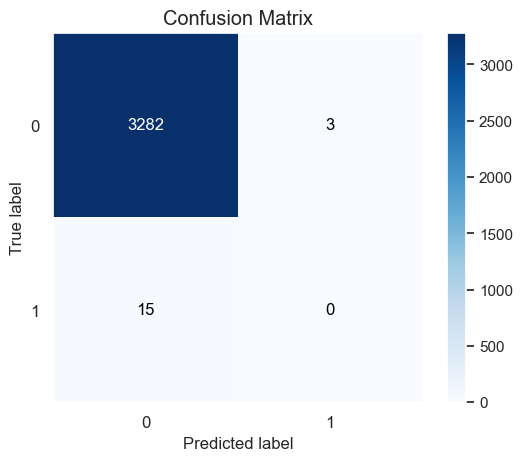

Classification Report for column 6:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3294
           1       0.00      0.00      0.00         6

    accuracy                           1.00      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       1.00      1.00      1.00      3300



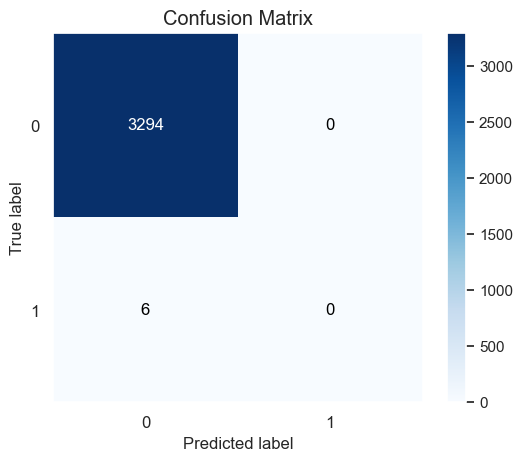

In [32]:
print("Classification Report for column 0:\n", classification_report(y_test[:,0], yhat_lgb[:,0]))
tn, fp, fn, tp = confusion_matrix(y_test[:,0], yhat_lgb[:,0]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,0], yhat_lgb[:,0], normalize=False)
plt.show()

print("Classification Report for column 1:\n", classification_report(y_test[:,1], yhat_lgb[:,1]))
tn, fp, fn, tp = confusion_matrix(y_test[:,1], yhat_lgb[:,1]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,1], yhat_lgb[:,1], normalize=False)
plt.show()

print("Classification Report for column 2:\n", classification_report(y_test[:,2], yhat_lgb[:,2]))
tn, fp, fn, tp = confusion_matrix(y_test[:,2], yhat_lgb[:,2]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,2], yhat_lgb[:,2], normalize=False)
plt.show()

print("Classification Report for column 3:\n", classification_report(y_test[:,3], yhat_lgb[:,3]))
tn, fp, fn, tp = confusion_matrix(y_test[:,3], yhat_lgb[:,3]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,3], yhat_lgb[:,3], normalize=False)
plt.show()

print("Classification Report for column 4:\n", classification_report(y_test[:,4], yhat_lgb[:,4]))
tn, fp, fn, tp = confusion_matrix(y_test[:,4], yhat_lgb[:,4]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,4], yhat_lgb[:,4], normalize=False)
plt.show()

print("Classification Report for column 5:\n", classification_report(y_test[:,5], yhat_lgb[:,5]))
tn, fp, fn, tp = confusion_matrix(y_test[:,5], yhat_lgb[:,5]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,5], yhat_lgb[:,5], normalize=False)
plt.show()

print("Classification Report for column 6:\n", classification_report(y_test[:,6], yhat_lgb[:,6]))
tn, fp, fn, tp = confusion_matrix(y_test[:,6], yhat_lgb[:,6]).ravel()
skplt.metrics.plot_confusion_matrix(y_test[:,6], yhat_lgb[:,6], normalize=False)
plt.show()


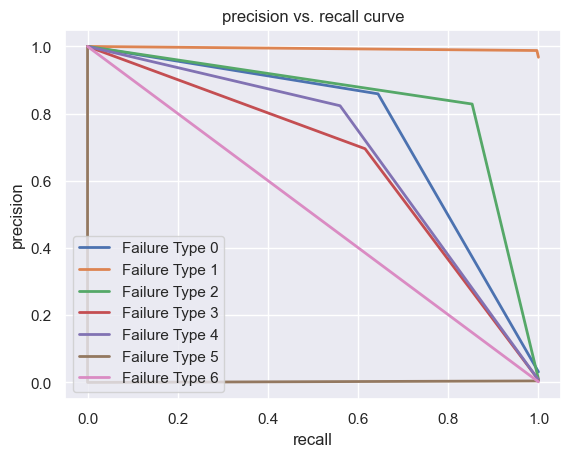

In [33]:
precision = dict()
recall = dict()
n_classes = 7
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],
                                                        yhat_lgb[:,i])
    plt.plot(recall[i], precision[i], lw=2, label='Failure Type {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


In [34]:
ranforest = RandomForestClassifier()
moc = MultiOutputClassifier(estimator=ranforest)
moc.fit(x_train,y_train)


MultiOutputClassifier(estimator=RandomForestClassifier())

In [35]:
print(round(moc.score(x_test,y_test)*100))

97


In [36]:
y_pred_moc=moc.predict(x_test)
y_pred_moc

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [37]:
for i in range(y_test.shape[1]):
    print("Column %d:" % i)
    print("  Accuracy Score: %.4f" % (accuracy_score(y_test[:, i], y_pred_moc[:, i])*100))
    print("  Average Precision Score: %.4f" % (average_precision_score(y_test[:, i], y_pred_moc[:, i])*100))
    print("  Matthews correlation coefficient: %.4f" % (matthews_corrcoef(y_test[:, i], y_pred_moc[:, i])*100))



Column 0:
  Accuracy Score: 98.0909
  Average Precision Score: 42.6054
  Matthews correlation coefficient: 63.1985
Column 1:
  Accuracy Score: 98.1515
  Average Precision Score: 98.3305
  Matthews correlation coefficient: 64.9842
Column 2:
  Accuracy Score: 99.4242
  Average Precision Score: 45.8630
  Matthews correlation coefficient: 67.1130
Column 3:
  Accuracy Score: 99.4848
  Average Precision Score: 35.1305
  Matthews correlation coefficient: 58.6827
Column 4:
  Accuracy Score: 99.6364
  Average Precision Score: 53.2442
  Matthews correlation coefficient: 72.5980
Column 5:
  Accuracy Score: 99.5455
  Average Precision Score: 0.4545
  Matthews correlation coefficient: 0.0000
Column 6:
  Accuracy Score: 99.8182
  Average Precision Score: 0.1818
  Matthews correlation coefficient: 0.0000


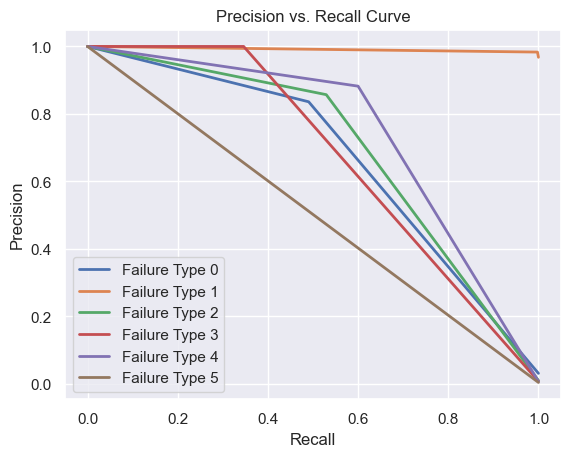

In [38]:
precision = dict()
recall = dict()
n_classes = 6
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_moc[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='Failure Type {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall Curve")
plt.show()


Classification Report for column 0:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3196
           1       0.84      0.49      0.62       104

    accuracy                           0.98      3300
   macro avg       0.91      0.74      0.80      3300
weighted avg       0.98      0.98      0.98      3300



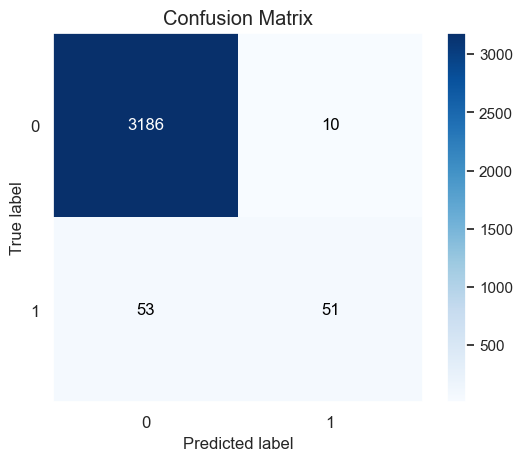

Classification Report for column 1:
               precision    recall  f1-score   support

           0       0.88      0.49      0.63       106
           1       0.98      1.00      0.99      3194

    accuracy                           0.98      3300
   macro avg       0.93      0.74      0.81      3300
weighted avg       0.98      0.98      0.98      3300



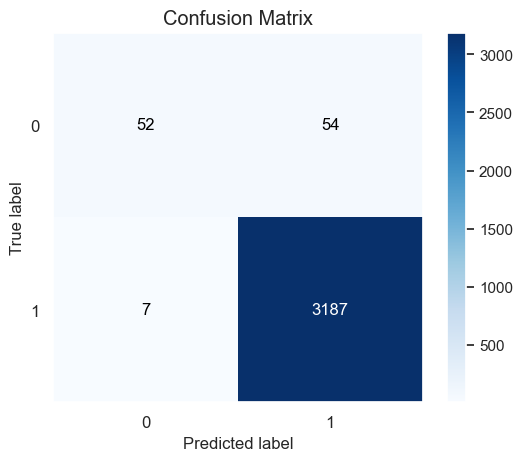

Classification Report for column 2:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3266
           1       0.86      0.53      0.65        34

    accuracy                           0.99      3300
   macro avg       0.93      0.76      0.83      3300
weighted avg       0.99      0.99      0.99      3300



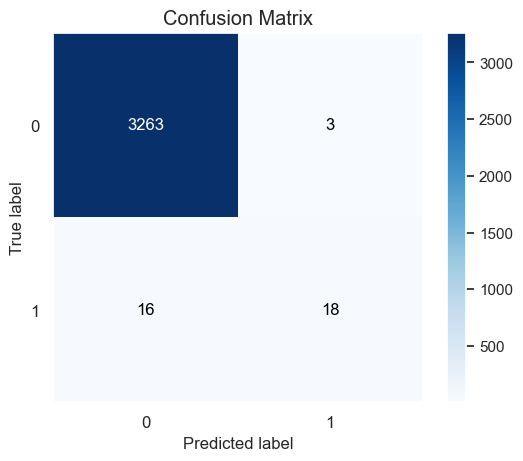

Classification Report for column 3:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3274
           1       1.00      0.35      0.51        26

    accuracy                           0.99      3300
   macro avg       1.00      0.67      0.76      3300
weighted avg       0.99      0.99      0.99      3300



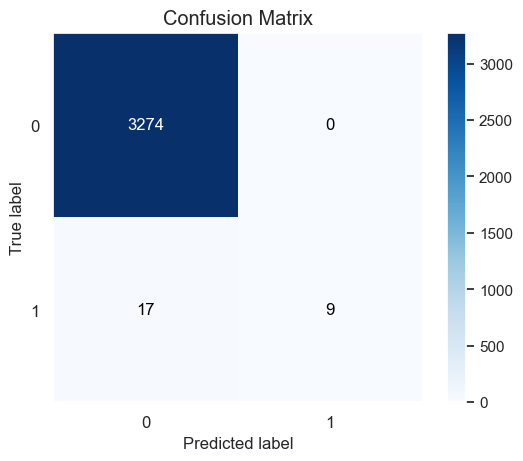

Classification Report for column 4:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3275
           1       0.88      0.60      0.71        25

    accuracy                           1.00      3300
   macro avg       0.94      0.80      0.86      3300
weighted avg       1.00      1.00      1.00      3300



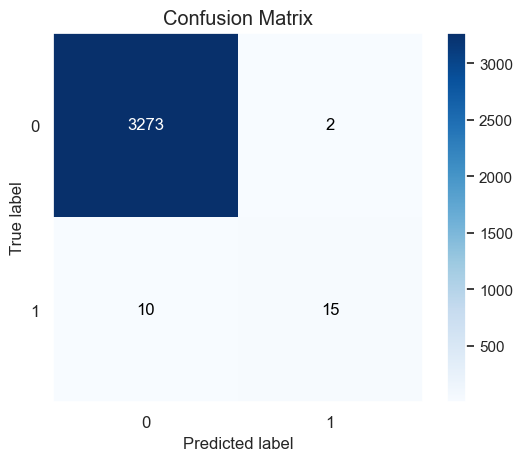

Classification Report for column 5:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3285
           1       0.00      0.00      0.00        15

    accuracy                           1.00      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       0.99      1.00      0.99      3300



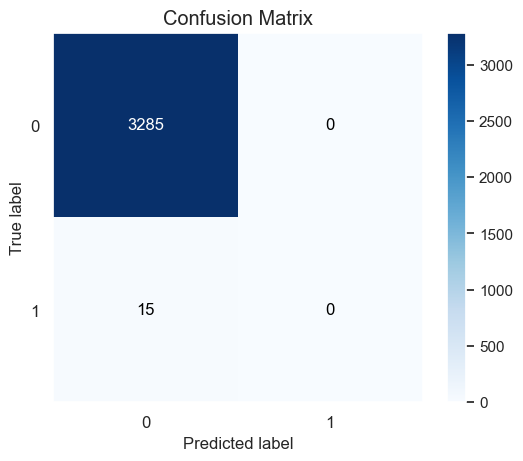

Classification Report for column 6:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3294
           1       0.00      0.00      0.00         6

    accuracy                           1.00      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       1.00      1.00      1.00      3300



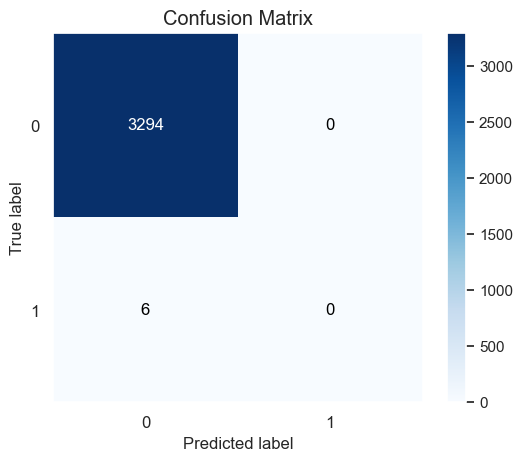

In [39]:
for i in range(y_test.shape[1]):
    print("Classification Report for column %d:\n" % i, classification_report(y_test[:, i], y_pred_moc[:, i]))
    tn, fp, fn, tp = confusion_matrix(y_test[:, i], y_pred_moc[:, i]).ravel()
    skplt.metrics.plot_confusion_matrix(y_test[:, i], y_pred_moc[:, i], normalize=False)
    plt.show()


In [40]:
catb = CatBoostClassifier()
model_catb = MultiOutputClassifier(estimator=catb)

In [41]:
model_catb.fit(x_train, y_train)
print(model_catb.score(x_test, y_test)*100)

Learning rate set to 0.02321
0:	learn: 0.6452194	total: 190ms	remaining: 3m 10s
1:	learn: 0.6068105	total: 197ms	remaining: 1m 38s
2:	learn: 0.5633291	total: 203ms	remaining: 1m 7s
3:	learn: 0.5226628	total: 210ms	remaining: 52.2s
4:	learn: 0.4921186	total: 216ms	remaining: 42.9s
5:	learn: 0.4629947	total: 222ms	remaining: 36.8s
6:	learn: 0.4323990	total: 228ms	remaining: 32.4s
7:	learn: 0.4096527	total: 235ms	remaining: 29.1s
8:	learn: 0.3875379	total: 241ms	remaining: 26.6s
9:	learn: 0.3664919	total: 247ms	remaining: 24.4s
10:	learn: 0.3468764	total: 255ms	remaining: 22.9s
11:	learn: 0.3290879	total: 260ms	remaining: 21.4s
12:	learn: 0.3128798	total: 266ms	remaining: 20.2s
13:	learn: 0.3001575	total: 273ms	remaining: 19.2s
14:	learn: 0.2838631	total: 279ms	remaining: 18.3s
15:	learn: 0.2713666	total: 286ms	remaining: 17.6s
16:	learn: 0.2580488	total: 294ms	remaining: 17s
17:	learn: 0.2455752	total: 300ms	remaining: 16.4s
18:	learn: 0.2333603	total: 307ms	remaining: 15.8s
19:	learn: 0

183:	learn: 0.0450532	total: 1.42s	remaining: 6.31s
184:	learn: 0.0449385	total: 1.43s	remaining: 6.3s
185:	learn: 0.0447622	total: 1.44s	remaining: 6.29s
186:	learn: 0.0446243	total: 1.44s	remaining: 6.27s
187:	learn: 0.0445606	total: 1.45s	remaining: 6.26s
188:	learn: 0.0445118	total: 1.46s	remaining: 6.25s
189:	learn: 0.0444539	total: 1.46s	remaining: 6.23s
190:	learn: 0.0441871	total: 1.47s	remaining: 6.22s
191:	learn: 0.0441173	total: 1.48s	remaining: 6.21s
192:	learn: 0.0439883	total: 1.48s	remaining: 6.2s
193:	learn: 0.0438475	total: 1.49s	remaining: 6.19s
194:	learn: 0.0437606	total: 1.5s	remaining: 6.17s
195:	learn: 0.0436545	total: 1.5s	remaining: 6.16s
196:	learn: 0.0435498	total: 1.51s	remaining: 6.15s
197:	learn: 0.0435062	total: 1.51s	remaining: 6.13s
198:	learn: 0.0434057	total: 1.52s	remaining: 6.13s
199:	learn: 0.0430453	total: 1.53s	remaining: 6.12s
200:	learn: 0.0430084	total: 1.54s	remaining: 6.11s
201:	learn: 0.0428800	total: 1.54s	remaining: 6.09s
202:	learn: 0.04

364:	learn: 0.0313769	total: 2.65s	remaining: 4.61s
365:	learn: 0.0313427	total: 2.66s	remaining: 4.61s
366:	learn: 0.0312969	total: 2.67s	remaining: 4.6s
367:	learn: 0.0311999	total: 2.67s	remaining: 4.59s
368:	learn: 0.0311561	total: 2.68s	remaining: 4.58s
369:	learn: 0.0311053	total: 2.69s	remaining: 4.57s
370:	learn: 0.0310103	total: 2.69s	remaining: 4.57s
371:	learn: 0.0309356	total: 2.71s	remaining: 4.57s
372:	learn: 0.0309184	total: 2.71s	remaining: 4.56s
373:	learn: 0.0308993	total: 2.72s	remaining: 4.55s
374:	learn: 0.0308541	total: 2.73s	remaining: 4.54s
375:	learn: 0.0308371	total: 2.73s	remaining: 4.53s
376:	learn: 0.0307781	total: 2.74s	remaining: 4.53s
377:	learn: 0.0307502	total: 2.75s	remaining: 4.52s
378:	learn: 0.0307211	total: 2.75s	remaining: 4.51s
379:	learn: 0.0306997	total: 2.76s	remaining: 4.5s
380:	learn: 0.0306654	total: 2.77s	remaining: 4.5s
381:	learn: 0.0305959	total: 2.77s	remaining: 4.49s
382:	learn: 0.0305660	total: 2.78s	remaining: 4.48s
383:	learn: 0.0

540:	learn: 0.0250426	total: 3.85s	remaining: 3.27s
541:	learn: 0.0250090	total: 3.86s	remaining: 3.26s
542:	learn: 0.0249648	total: 3.87s	remaining: 3.25s
543:	learn: 0.0249239	total: 3.88s	remaining: 3.25s
544:	learn: 0.0249107	total: 3.88s	remaining: 3.24s
545:	learn: 0.0248823	total: 3.89s	remaining: 3.23s
546:	learn: 0.0247870	total: 3.89s	remaining: 3.22s
547:	learn: 0.0247670	total: 3.9s	remaining: 3.22s
548:	learn: 0.0247444	total: 3.91s	remaining: 3.21s
549:	learn: 0.0247157	total: 3.92s	remaining: 3.2s
550:	learn: 0.0246834	total: 3.92s	remaining: 3.2s
551:	learn: 0.0246438	total: 3.93s	remaining: 3.19s
552:	learn: 0.0246035	total: 3.94s	remaining: 3.19s
553:	learn: 0.0245931	total: 3.95s	remaining: 3.18s
554:	learn: 0.0245757	total: 3.96s	remaining: 3.17s
555:	learn: 0.0245473	total: 3.96s	remaining: 3.17s
556:	learn: 0.0245361	total: 3.97s	remaining: 3.16s
557:	learn: 0.0245244	total: 3.98s	remaining: 3.15s
558:	learn: 0.0245049	total: 3.98s	remaining: 3.14s
559:	learn: 0.0

724:	learn: 0.0197744	total: 5.06s	remaining: 1.92s
725:	learn: 0.0197619	total: 5.07s	remaining: 1.91s
726:	learn: 0.0197461	total: 5.08s	remaining: 1.91s
727:	learn: 0.0197380	total: 5.08s	remaining: 1.9s
728:	learn: 0.0197231	total: 5.09s	remaining: 1.89s
729:	learn: 0.0197030	total: 5.1s	remaining: 1.89s
730:	learn: 0.0196632	total: 5.11s	remaining: 1.88s
731:	learn: 0.0196308	total: 5.11s	remaining: 1.87s
732:	learn: 0.0196094	total: 5.12s	remaining: 1.86s
733:	learn: 0.0195956	total: 5.13s	remaining: 1.86s
734:	learn: 0.0195810	total: 5.13s	remaining: 1.85s
735:	learn: 0.0195669	total: 5.14s	remaining: 1.84s
736:	learn: 0.0195250	total: 5.14s	remaining: 1.84s
737:	learn: 0.0195117	total: 5.15s	remaining: 1.83s
738:	learn: 0.0194779	total: 5.16s	remaining: 1.82s
739:	learn: 0.0194347	total: 5.17s	remaining: 1.82s
740:	learn: 0.0194067	total: 5.18s	remaining: 1.81s
741:	learn: 0.0193825	total: 5.18s	remaining: 1.8s
742:	learn: 0.0193518	total: 5.19s	remaining: 1.79s
743:	learn: 0.0

900:	learn: 0.0164079	total: 6.24s	remaining: 686ms
901:	learn: 0.0163897	total: 6.25s	remaining: 679ms
902:	learn: 0.0163691	total: 6.25s	remaining: 672ms
903:	learn: 0.0163635	total: 6.26s	remaining: 665ms
904:	learn: 0.0163461	total: 6.26s	remaining: 658ms
905:	learn: 0.0163163	total: 6.27s	remaining: 651ms
906:	learn: 0.0163069	total: 6.28s	remaining: 644ms
907:	learn: 0.0163012	total: 6.29s	remaining: 637ms
908:	learn: 0.0162840	total: 6.3s	remaining: 631ms
909:	learn: 0.0162714	total: 6.3s	remaining: 624ms
910:	learn: 0.0162592	total: 6.31s	remaining: 617ms
911:	learn: 0.0162559	total: 6.32s	remaining: 610ms
912:	learn: 0.0162505	total: 6.32s	remaining: 603ms
913:	learn: 0.0162382	total: 6.33s	remaining: 596ms
914:	learn: 0.0162243	total: 6.33s	remaining: 589ms
915:	learn: 0.0162073	total: 6.34s	remaining: 582ms
916:	learn: 0.0161829	total: 6.35s	remaining: 575ms
917:	learn: 0.0161571	total: 6.36s	remaining: 568ms
918:	learn: 0.0161539	total: 6.36s	remaining: 561ms
919:	learn: 0.

60:	learn: 0.0837788	total: 402ms	remaining: 6.18s
61:	learn: 0.0830415	total: 408ms	remaining: 6.17s
62:	learn: 0.0820855	total: 415ms	remaining: 6.17s
63:	learn: 0.0811802	total: 420ms	remaining: 6.15s
64:	learn: 0.0807718	total: 432ms	remaining: 6.21s
65:	learn: 0.0800662	total: 438ms	remaining: 6.19s
66:	learn: 0.0790553	total: 444ms	remaining: 6.18s
67:	learn: 0.0786135	total: 450ms	remaining: 6.16s
68:	learn: 0.0780624	total: 455ms	remaining: 6.14s
69:	learn: 0.0774387	total: 462ms	remaining: 6.14s
70:	learn: 0.0767838	total: 472ms	remaining: 6.17s
71:	learn: 0.0759135	total: 481ms	remaining: 6.2s
72:	learn: 0.0753869	total: 489ms	remaining: 6.2s
73:	learn: 0.0749266	total: 499ms	remaining: 6.25s
74:	learn: 0.0744126	total: 514ms	remaining: 6.33s
75:	learn: 0.0738701	total: 524ms	remaining: 6.38s
76:	learn: 0.0735895	total: 567ms	remaining: 6.79s
77:	learn: 0.0728360	total: 581ms	remaining: 6.87s
78:	learn: 0.0720382	total: 592ms	remaining: 6.91s
79:	learn: 0.0716764	total: 604ms

229:	learn: 0.0444120	total: 1.81s	remaining: 6.08s
230:	learn: 0.0443712	total: 1.82s	remaining: 6.06s
231:	learn: 0.0443399	total: 1.83s	remaining: 6.05s
232:	learn: 0.0442964	total: 1.83s	remaining: 6.04s
233:	learn: 0.0442194	total: 1.84s	remaining: 6.03s
234:	learn: 0.0441958	total: 1.85s	remaining: 6.01s
235:	learn: 0.0440927	total: 1.85s	remaining: 6s
236:	learn: 0.0439762	total: 1.86s	remaining: 5.99s
237:	learn: 0.0438569	total: 1.87s	remaining: 5.97s
238:	learn: 0.0437889	total: 1.87s	remaining: 5.96s
239:	learn: 0.0437335	total: 1.88s	remaining: 5.96s
240:	learn: 0.0436267	total: 1.89s	remaining: 5.95s
241:	learn: 0.0435656	total: 1.9s	remaining: 5.94s
242:	learn: 0.0435006	total: 1.9s	remaining: 5.93s
243:	learn: 0.0434119	total: 1.91s	remaining: 5.91s
244:	learn: 0.0433295	total: 1.91s	remaining: 5.9s
245:	learn: 0.0432141	total: 1.92s	remaining: 5.88s
246:	learn: 0.0431410	total: 1.93s	remaining: 5.87s
247:	learn: 0.0430678	total: 1.93s	remaining: 5.86s
248:	learn: 0.0429

411:	learn: 0.0333910	total: 3.04s	remaining: 4.33s
412:	learn: 0.0333686	total: 3.04s	remaining: 4.32s
413:	learn: 0.0333147	total: 3.05s	remaining: 4.32s
414:	learn: 0.0331980	total: 3.06s	remaining: 4.31s
415:	learn: 0.0331167	total: 3.06s	remaining: 4.3s
416:	learn: 0.0330623	total: 3.07s	remaining: 4.3s
417:	learn: 0.0329816	total: 3.08s	remaining: 4.29s
418:	learn: 0.0329471	total: 3.09s	remaining: 4.28s
419:	learn: 0.0329059	total: 3.1s	remaining: 4.27s
420:	learn: 0.0328065	total: 3.1s	remaining: 4.26s
421:	learn: 0.0327957	total: 3.11s	remaining: 4.26s
422:	learn: 0.0327446	total: 3.11s	remaining: 4.25s
423:	learn: 0.0327093	total: 3.12s	remaining: 4.24s
424:	learn: 0.0326658	total: 3.13s	remaining: 4.23s
425:	learn: 0.0326248	total: 3.13s	remaining: 4.22s
426:	learn: 0.0326131	total: 3.14s	remaining: 4.21s
427:	learn: 0.0325752	total: 3.15s	remaining: 4.21s
428:	learn: 0.0325271	total: 3.16s	remaining: 4.21s
429:	learn: 0.0324462	total: 3.17s	remaining: 4.2s
430:	learn: 0.032

570:	learn: 0.0273665	total: 4.47s	remaining: 3.36s
571:	learn: 0.0273171	total: 4.48s	remaining: 3.35s
572:	learn: 0.0273064	total: 4.49s	remaining: 3.34s
573:	learn: 0.0272616	total: 4.5s	remaining: 3.34s
574:	learn: 0.0272506	total: 4.51s	remaining: 3.33s
575:	learn: 0.0272394	total: 4.53s	remaining: 3.34s
576:	learn: 0.0272177	total: 4.55s	remaining: 3.34s
577:	learn: 0.0272073	total: 4.56s	remaining: 3.33s
578:	learn: 0.0271856	total: 4.57s	remaining: 3.32s
579:	learn: 0.0271627	total: 4.58s	remaining: 3.31s
580:	learn: 0.0271531	total: 4.58s	remaining: 3.31s
581:	learn: 0.0271316	total: 4.59s	remaining: 3.3s
582:	learn: 0.0270999	total: 4.6s	remaining: 3.29s
583:	learn: 0.0270695	total: 4.61s	remaining: 3.28s
584:	learn: 0.0270369	total: 4.61s	remaining: 3.27s
585:	learn: 0.0270141	total: 4.62s	remaining: 3.26s
586:	learn: 0.0269706	total: 4.63s	remaining: 3.26s
587:	learn: 0.0269098	total: 4.63s	remaining: 3.25s
588:	learn: 0.0268418	total: 4.64s	remaining: 3.24s
589:	learn: 0.0

749:	learn: 0.0225610	total: 6.13s	remaining: 2.04s
750:	learn: 0.0225610	total: 6.13s	remaining: 2.03s
751:	learn: 0.0225297	total: 6.14s	remaining: 2.02s
752:	learn: 0.0225297	total: 6.14s	remaining: 2.02s
753:	learn: 0.0225297	total: 6.15s	remaining: 2.01s
754:	learn: 0.0225250	total: 6.16s	remaining: 2s
755:	learn: 0.0225038	total: 6.16s	remaining: 1.99s
756:	learn: 0.0224864	total: 6.17s	remaining: 1.98s
757:	learn: 0.0224864	total: 6.17s	remaining: 1.97s
758:	learn: 0.0224818	total: 6.18s	remaining: 1.96s
759:	learn: 0.0224818	total: 6.19s	remaining: 1.95s
760:	learn: 0.0224818	total: 6.19s	remaining: 1.95s
761:	learn: 0.0224818	total: 6.2s	remaining: 1.94s
762:	learn: 0.0224818	total: 6.2s	remaining: 1.93s
763:	learn: 0.0224817	total: 6.21s	remaining: 1.92s
764:	learn: 0.0224818	total: 6.21s	remaining: 1.91s
765:	learn: 0.0224817	total: 6.22s	remaining: 1.9s
766:	learn: 0.0224818	total: 6.23s	remaining: 1.89s
767:	learn: 0.0224817	total: 6.23s	remaining: 1.88s
768:	learn: 0.0224

927:	learn: 0.0211128	total: 7.34s	remaining: 569ms
928:	learn: 0.0211103	total: 7.34s	remaining: 561ms
929:	learn: 0.0210861	total: 7.35s	remaining: 553ms
930:	learn: 0.0210861	total: 7.36s	remaining: 545ms
931:	learn: 0.0210607	total: 7.37s	remaining: 537ms
932:	learn: 0.0210606	total: 7.37s	remaining: 529ms
933:	learn: 0.0210606	total: 7.38s	remaining: 522ms
934:	learn: 0.0210604	total: 7.39s	remaining: 513ms
935:	learn: 0.0210257	total: 7.39s	remaining: 506ms
936:	learn: 0.0210104	total: 7.4s	remaining: 498ms
937:	learn: 0.0210087	total: 7.41s	remaining: 490ms
938:	learn: 0.0210086	total: 7.41s	remaining: 482ms
939:	learn: 0.0209868	total: 7.42s	remaining: 474ms
940:	learn: 0.0209715	total: 7.43s	remaining: 466ms
941:	learn: 0.0209478	total: 7.44s	remaining: 458ms
942:	learn: 0.0209314	total: 7.45s	remaining: 450ms
943:	learn: 0.0209211	total: 7.45s	remaining: 442ms
944:	learn: 0.0209064	total: 7.46s	remaining: 434ms
945:	learn: 0.0208879	total: 7.47s	remaining: 426ms
946:	learn: 0

100:	learn: 0.0066901	total: 817ms	remaining: 7.27s
101:	learn: 0.0065846	total: 830ms	remaining: 7.31s
102:	learn: 0.0064993	total: 836ms	remaining: 7.28s
103:	learn: 0.0064320	total: 843ms	remaining: 7.26s
104:	learn: 0.0063888	total: 850ms	remaining: 7.24s
105:	learn: 0.0063111	total: 861ms	remaining: 7.26s
106:	learn: 0.0062099	total: 869ms	remaining: 7.25s
107:	learn: 0.0060931	total: 878ms	remaining: 7.25s
108:	learn: 0.0060217	total: 884ms	remaining: 7.22s
109:	learn: 0.0059839	total: 891ms	remaining: 7.21s
110:	learn: 0.0059033	total: 897ms	remaining: 7.19s
111:	learn: 0.0058554	total: 904ms	remaining: 7.17s
112:	learn: 0.0058133	total: 910ms	remaining: 7.15s
113:	learn: 0.0057869	total: 925ms	remaining: 7.19s
114:	learn: 0.0057269	total: 940ms	remaining: 7.24s
115:	learn: 0.0056465	total: 947ms	remaining: 7.21s
116:	learn: 0.0055791	total: 955ms	remaining: 7.2s
117:	learn: 0.0055434	total: 961ms	remaining: 7.18s
118:	learn: 0.0054843	total: 968ms	remaining: 7.17s
119:	learn: 0

265:	learn: 0.0023265	total: 2.01s	remaining: 5.55s
266:	learn: 0.0023163	total: 2.02s	remaining: 5.54s
267:	learn: 0.0023052	total: 2.02s	remaining: 5.53s
268:	learn: 0.0023022	total: 2.03s	remaining: 5.52s
269:	learn: 0.0022960	total: 2.04s	remaining: 5.51s
270:	learn: 0.0022923	total: 2.05s	remaining: 5.5s
271:	learn: 0.0022654	total: 2.05s	remaining: 5.49s
272:	learn: 0.0022496	total: 2.06s	remaining: 5.48s
273:	learn: 0.0022452	total: 2.06s	remaining: 5.47s
274:	learn: 0.0022414	total: 2.07s	remaining: 5.47s
275:	learn: 0.0022368	total: 2.08s	remaining: 5.46s
276:	learn: 0.0022323	total: 2.09s	remaining: 5.45s
277:	learn: 0.0022267	total: 2.09s	remaining: 5.44s
278:	learn: 0.0022236	total: 2.1s	remaining: 5.42s
279:	learn: 0.0022143	total: 2.11s	remaining: 5.42s
280:	learn: 0.0022063	total: 2.11s	remaining: 5.4s
281:	learn: 0.0021907	total: 2.12s	remaining: 5.39s
282:	learn: 0.0021854	total: 2.12s	remaining: 5.38s
283:	learn: 0.0021822	total: 2.13s	remaining: 5.37s
284:	learn: 0.0

432:	learn: 0.0012491	total: 3.22s	remaining: 4.22s
433:	learn: 0.0012479	total: 3.23s	remaining: 4.21s
434:	learn: 0.0012383	total: 3.23s	remaining: 4.2s
435:	learn: 0.0012371	total: 3.24s	remaining: 4.19s
436:	learn: 0.0012358	total: 3.26s	remaining: 4.21s
437:	learn: 0.0012340	total: 3.27s	remaining: 4.2s
438:	learn: 0.0012329	total: 3.28s	remaining: 4.19s
439:	learn: 0.0012318	total: 3.28s	remaining: 4.18s
440:	learn: 0.0012305	total: 3.29s	remaining: 4.17s
441:	learn: 0.0012295	total: 3.3s	remaining: 4.16s
442:	learn: 0.0012282	total: 3.3s	remaining: 4.15s
443:	learn: 0.0012270	total: 3.31s	remaining: 4.14s
444:	learn: 0.0012232	total: 3.32s	remaining: 4.14s
445:	learn: 0.0012125	total: 3.32s	remaining: 4.13s
446:	learn: 0.0012097	total: 3.33s	remaining: 4.12s
447:	learn: 0.0012080	total: 3.33s	remaining: 4.11s
448:	learn: 0.0012068	total: 3.34s	remaining: 4.1s
449:	learn: 0.0012050	total: 3.35s	remaining: 4.09s
450:	learn: 0.0012015	total: 3.35s	remaining: 4.08s
451:	learn: 0.001

612:	learn: 0.0008895	total: 4.65s	remaining: 2.93s
613:	learn: 0.0008822	total: 4.66s	remaining: 2.93s
614:	learn: 0.0008814	total: 4.67s	remaining: 2.92s
615:	learn: 0.0008810	total: 4.67s	remaining: 2.91s
616:	learn: 0.0008806	total: 4.68s	remaining: 2.9s
617:	learn: 0.0008802	total: 4.69s	remaining: 2.9s
618:	learn: 0.0008767	total: 4.7s	remaining: 2.89s
619:	learn: 0.0008761	total: 4.7s	remaining: 2.88s
620:	learn: 0.0008757	total: 4.71s	remaining: 2.87s
621:	learn: 0.0008753	total: 4.72s	remaining: 2.87s
622:	learn: 0.0008745	total: 4.72s	remaining: 2.86s
623:	learn: 0.0008667	total: 4.73s	remaining: 2.85s
624:	learn: 0.0008619	total: 4.74s	remaining: 2.84s
625:	learn: 0.0008600	total: 4.74s	remaining: 2.83s
626:	learn: 0.0008596	total: 4.75s	remaining: 2.82s
627:	learn: 0.0008588	total: 4.76s	remaining: 2.82s
628:	learn: 0.0008530	total: 4.77s	remaining: 2.81s
629:	learn: 0.0008456	total: 4.78s	remaining: 2.81s
630:	learn: 0.0008390	total: 4.79s	remaining: 2.8s
631:	learn: 0.000

782:	learn: 0.0005390	total: 5.89s	remaining: 1.63s
783:	learn: 0.0005380	total: 5.9s	remaining: 1.63s
784:	learn: 0.0005374	total: 5.91s	remaining: 1.62s
785:	learn: 0.0005357	total: 5.91s	remaining: 1.61s
786:	learn: 0.0005338	total: 5.92s	remaining: 1.6s
787:	learn: 0.0005334	total: 5.93s	remaining: 1.59s
788:	learn: 0.0005312	total: 5.93s	remaining: 1.59s
789:	learn: 0.0005295	total: 5.94s	remaining: 1.58s
790:	learn: 0.0005293	total: 5.95s	remaining: 1.57s
791:	learn: 0.0005286	total: 5.95s	remaining: 1.56s
792:	learn: 0.0005269	total: 5.96s	remaining: 1.55s
793:	learn: 0.0005266	total: 5.96s	remaining: 1.55s
794:	learn: 0.0005249	total: 5.97s	remaining: 1.54s
795:	learn: 0.0005243	total: 5.98s	remaining: 1.53s
796:	learn: 0.0005237	total: 5.98s	remaining: 1.52s
797:	learn: 0.0005231	total: 5.99s	remaining: 1.52s
798:	learn: 0.0005228	total: 6s	remaining: 1.51s
799:	learn: 0.0005222	total: 6s	remaining: 1.5s
800:	learn: 0.0005219	total: 6.01s	remaining: 1.49s
801:	learn: 0.0005213

950:	learn: 0.0004264	total: 6.93s	remaining: 357ms
951:	learn: 0.0004263	total: 6.93s	remaining: 350ms
952:	learn: 0.0004260	total: 6.94s	remaining: 342ms
953:	learn: 0.0004245	total: 6.95s	remaining: 335ms
954:	learn: 0.0004232	total: 6.95s	remaining: 328ms
955:	learn: 0.0004230	total: 6.96s	remaining: 320ms
956:	learn: 0.0004229	total: 6.96s	remaining: 313ms
957:	learn: 0.0004228	total: 6.97s	remaining: 306ms
958:	learn: 0.0004226	total: 6.97s	remaining: 298ms
959:	learn: 0.0004225	total: 6.98s	remaining: 291ms
960:	learn: 0.0004224	total: 6.99s	remaining: 284ms
961:	learn: 0.0004221	total: 6.99s	remaining: 276ms
962:	learn: 0.0004218	total: 7s	remaining: 269ms
963:	learn: 0.0004217	total: 7s	remaining: 262ms
964:	learn: 0.0004216	total: 7.01s	remaining: 254ms
965:	learn: 0.0004214	total: 7.02s	remaining: 247ms
966:	learn: 0.0004213	total: 7.02s	remaining: 240ms
967:	learn: 0.0004211	total: 7.03s	remaining: 232ms
968:	learn: 0.0004210	total: 7.03s	remaining: 225ms
969:	learn: 0.0004

133:	learn: 0.0051456	total: 829ms	remaining: 5.36s
134:	learn: 0.0051121	total: 835ms	remaining: 5.35s
135:	learn: 0.0050802	total: 841ms	remaining: 5.34s
136:	learn: 0.0050358	total: 847ms	remaining: 5.34s
137:	learn: 0.0049790	total: 853ms	remaining: 5.33s
138:	learn: 0.0049342	total: 859ms	remaining: 5.32s
139:	learn: 0.0048649	total: 865ms	remaining: 5.32s
140:	learn: 0.0048241	total: 871ms	remaining: 5.31s
141:	learn: 0.0048110	total: 877ms	remaining: 5.3s
142:	learn: 0.0047482	total: 884ms	remaining: 5.29s
143:	learn: 0.0046940	total: 890ms	remaining: 5.29s
144:	learn: 0.0046805	total: 896ms	remaining: 5.28s
145:	learn: 0.0046278	total: 901ms	remaining: 5.27s
146:	learn: 0.0046013	total: 907ms	remaining: 5.26s
147:	learn: 0.0045533	total: 913ms	remaining: 5.26s
148:	learn: 0.0045390	total: 919ms	remaining: 5.25s
149:	learn: 0.0044860	total: 925ms	remaining: 5.24s
150:	learn: 0.0044258	total: 932ms	remaining: 5.24s
151:	learn: 0.0043990	total: 937ms	remaining: 5.23s
152:	learn: 0

307:	learn: 0.0018525	total: 1.83s	remaining: 4.11s
308:	learn: 0.0018479	total: 1.83s	remaining: 4.1s
309:	learn: 0.0018344	total: 1.84s	remaining: 4.09s
310:	learn: 0.0018315	total: 1.84s	remaining: 4.09s
311:	learn: 0.0018295	total: 1.85s	remaining: 4.08s
312:	learn: 0.0018264	total: 1.85s	remaining: 4.07s
313:	learn: 0.0018211	total: 1.86s	remaining: 4.07s
314:	learn: 0.0018142	total: 1.87s	remaining: 4.06s
315:	learn: 0.0018089	total: 1.87s	remaining: 4.05s
316:	learn: 0.0018027	total: 1.88s	remaining: 4.04s
317:	learn: 0.0017908	total: 1.88s	remaining: 4.04s
318:	learn: 0.0017844	total: 1.89s	remaining: 4.03s
319:	learn: 0.0017828	total: 1.89s	remaining: 4.02s
320:	learn: 0.0017789	total: 1.9s	remaining: 4.01s
321:	learn: 0.0017767	total: 1.9s	remaining: 4.01s
322:	learn: 0.0017657	total: 1.91s	remaining: 4s
323:	learn: 0.0017525	total: 1.91s	remaining: 3.99s
324:	learn: 0.0017439	total: 1.92s	remaining: 3.99s
325:	learn: 0.0017338	total: 1.93s	remaining: 3.98s
326:	learn: 0.0017

490:	learn: 0.0010625	total: 2.86s	remaining: 2.96s
491:	learn: 0.0010606	total: 2.86s	remaining: 2.96s
492:	learn: 0.0010564	total: 2.87s	remaining: 2.95s
493:	learn: 0.0010557	total: 2.88s	remaining: 2.94s
494:	learn: 0.0010550	total: 2.88s	remaining: 2.94s
495:	learn: 0.0010543	total: 2.89s	remaining: 2.93s
496:	learn: 0.0010476	total: 2.89s	remaining: 2.93s
497:	learn: 0.0010469	total: 2.9s	remaining: 2.92s
498:	learn: 0.0010443	total: 2.9s	remaining: 2.92s
499:	learn: 0.0010426	total: 2.91s	remaining: 2.91s
500:	learn: 0.0010418	total: 2.92s	remaining: 2.9s
501:	learn: 0.0010396	total: 2.92s	remaining: 2.9s
502:	learn: 0.0010378	total: 2.93s	remaining: 2.89s
503:	learn: 0.0010361	total: 2.93s	remaining: 2.89s
504:	learn: 0.0010311	total: 2.94s	remaining: 2.88s
505:	learn: 0.0010271	total: 2.95s	remaining: 2.88s
506:	learn: 0.0010256	total: 2.95s	remaining: 2.87s
507:	learn: 0.0010217	total: 2.96s	remaining: 2.87s
508:	learn: 0.0010192	total: 2.96s	remaining: 2.86s
509:	learn: 0.00

665:	learn: 0.0007301	total: 3.86s	remaining: 1.94s
666:	learn: 0.0007291	total: 3.86s	remaining: 1.93s
667:	learn: 0.0007281	total: 3.87s	remaining: 1.92s
668:	learn: 0.0007271	total: 3.88s	remaining: 1.92s
669:	learn: 0.0007262	total: 3.88s	remaining: 1.91s
670:	learn: 0.0007235	total: 3.89s	remaining: 1.91s
671:	learn: 0.0007226	total: 3.89s	remaining: 1.9s
672:	learn: 0.0007216	total: 3.9s	remaining: 1.89s
673:	learn: 0.0007207	total: 3.9s	remaining: 1.89s
674:	learn: 0.0007200	total: 3.91s	remaining: 1.88s
675:	learn: 0.0007190	total: 3.92s	remaining: 1.88s
676:	learn: 0.0007180	total: 3.92s	remaining: 1.87s
677:	learn: 0.0007173	total: 3.93s	remaining: 1.86s
678:	learn: 0.0007140	total: 3.93s	remaining: 1.86s
679:	learn: 0.0007130	total: 3.94s	remaining: 1.85s
680:	learn: 0.0007103	total: 3.94s	remaining: 1.85s
681:	learn: 0.0007095	total: 3.95s	remaining: 1.84s
682:	learn: 0.0007086	total: 3.96s	remaining: 1.84s
683:	learn: 0.0007076	total: 3.96s	remaining: 1.83s
684:	learn: 0.0

844:	learn: 0.0005383	total: 4.86s	remaining: 891ms
845:	learn: 0.0005380	total: 4.86s	remaining: 885ms
846:	learn: 0.0005377	total: 4.87s	remaining: 880ms
847:	learn: 0.0005375	total: 4.88s	remaining: 874ms
848:	learn: 0.0005372	total: 4.88s	remaining: 868ms
849:	learn: 0.0005366	total: 4.89s	remaining: 863ms
850:	learn: 0.0005363	total: 4.89s	remaining: 857ms
851:	learn: 0.0005360	total: 4.9s	remaining: 851ms
852:	learn: 0.0005358	total: 4.91s	remaining: 845ms
853:	learn: 0.0005337	total: 4.91s	remaining: 840ms
854:	learn: 0.0005334	total: 4.92s	remaining: 834ms
855:	learn: 0.0005309	total: 4.92s	remaining: 828ms
856:	learn: 0.0005302	total: 4.93s	remaining: 822ms
857:	learn: 0.0005300	total: 4.93s	remaining: 816ms
858:	learn: 0.0005297	total: 4.94s	remaining: 811ms
859:	learn: 0.0005277	total: 4.94s	remaining: 805ms
860:	learn: 0.0005274	total: 4.95s	remaining: 799ms
861:	learn: 0.0005268	total: 4.96s	remaining: 793ms
862:	learn: 0.0005259	total: 4.96s	remaining: 788ms
863:	learn: 0

27:	learn: 0.0699277	total: 199ms	remaining: 6.91s
28:	learn: 0.0662913	total: 206ms	remaining: 6.89s
29:	learn: 0.0625002	total: 212ms	remaining: 6.84s
30:	learn: 0.0583505	total: 218ms	remaining: 6.81s
31:	learn: 0.0555692	total: 224ms	remaining: 6.77s
32:	learn: 0.0527378	total: 230ms	remaining: 6.75s
33:	learn: 0.0490610	total: 237ms	remaining: 6.72s
34:	learn: 0.0467884	total: 242ms	remaining: 6.68s
35:	learn: 0.0438840	total: 248ms	remaining: 6.65s
36:	learn: 0.0420199	total: 254ms	remaining: 6.61s
37:	learn: 0.0406795	total: 259ms	remaining: 6.57s
38:	learn: 0.0392133	total: 265ms	remaining: 6.53s
39:	learn: 0.0370535	total: 270ms	remaining: 6.49s
40:	learn: 0.0351403	total: 277ms	remaining: 6.47s
41:	learn: 0.0340867	total: 282ms	remaining: 6.44s
42:	learn: 0.0322324	total: 288ms	remaining: 6.4s
43:	learn: 0.0311218	total: 293ms	remaining: 6.37s
44:	learn: 0.0298861	total: 299ms	remaining: 6.35s
45:	learn: 0.0284661	total: 305ms	remaining: 6.32s
46:	learn: 0.0272434	total: 311m

194:	learn: 0.0054323	total: 1.19s	remaining: 4.91s
195:	learn: 0.0053951	total: 1.2s	remaining: 4.91s
196:	learn: 0.0053590	total: 1.2s	remaining: 4.91s
197:	learn: 0.0053418	total: 1.21s	remaining: 4.9s
198:	learn: 0.0053315	total: 1.22s	remaining: 4.9s
199:	learn: 0.0053100	total: 1.22s	remaining: 4.89s
200:	learn: 0.0052930	total: 1.23s	remaining: 4.89s
201:	learn: 0.0052647	total: 1.24s	remaining: 4.88s
202:	learn: 0.0052416	total: 1.24s	remaining: 4.88s
203:	learn: 0.0052108	total: 1.25s	remaining: 4.87s
204:	learn: 0.0051885	total: 1.25s	remaining: 4.87s
205:	learn: 0.0051752	total: 1.26s	remaining: 4.86s
206:	learn: 0.0051497	total: 1.27s	remaining: 4.85s
207:	learn: 0.0051218	total: 1.27s	remaining: 4.85s
208:	learn: 0.0051062	total: 1.28s	remaining: 4.84s
209:	learn: 0.0050752	total: 1.28s	remaining: 4.84s
210:	learn: 0.0050450	total: 1.29s	remaining: 4.83s
211:	learn: 0.0050334	total: 1.3s	remaining: 4.83s
212:	learn: 0.0049993	total: 1.3s	remaining: 4.82s
213:	learn: 0.0049

362:	learn: 0.0026790	total: 2.2s	remaining: 3.87s
363:	learn: 0.0026742	total: 2.21s	remaining: 3.86s
364:	learn: 0.0026621	total: 2.21s	remaining: 3.85s
365:	learn: 0.0026425	total: 2.22s	remaining: 3.85s
366:	learn: 0.0026367	total: 2.23s	remaining: 3.84s
367:	learn: 0.0026311	total: 2.23s	remaining: 3.83s
368:	learn: 0.0026214	total: 2.24s	remaining: 3.83s
369:	learn: 0.0026150	total: 2.24s	remaining: 3.82s
370:	learn: 0.0026010	total: 2.25s	remaining: 3.81s
371:	learn: 0.0025943	total: 2.25s	remaining: 3.81s
372:	learn: 0.0025877	total: 2.26s	remaining: 3.8s
373:	learn: 0.0025714	total: 2.27s	remaining: 3.79s
374:	learn: 0.0025604	total: 2.27s	remaining: 3.79s
375:	learn: 0.0025538	total: 2.28s	remaining: 3.78s
376:	learn: 0.0025503	total: 2.28s	remaining: 3.77s
377:	learn: 0.0025393	total: 2.29s	remaining: 3.77s
378:	learn: 0.0025265	total: 2.29s	remaining: 3.76s
379:	learn: 0.0025175	total: 2.3s	remaining: 3.75s
380:	learn: 0.0025051	total: 2.31s	remaining: 3.75s
381:	learn: 0.0

537:	learn: 0.0014875	total: 3.21s	remaining: 2.76s
538:	learn: 0.0014819	total: 3.22s	remaining: 2.75s
539:	learn: 0.0014764	total: 3.23s	remaining: 2.75s
540:	learn: 0.0014707	total: 3.23s	remaining: 2.74s
541:	learn: 0.0014665	total: 3.24s	remaining: 2.74s
542:	learn: 0.0014633	total: 3.24s	remaining: 2.73s
543:	learn: 0.0014577	total: 3.25s	remaining: 2.72s
544:	learn: 0.0014524	total: 3.26s	remaining: 2.72s
545:	learn: 0.0014490	total: 3.26s	remaining: 2.71s
546:	learn: 0.0014460	total: 3.27s	remaining: 2.71s
547:	learn: 0.0014430	total: 3.27s	remaining: 2.7s
548:	learn: 0.0014377	total: 3.28s	remaining: 2.69s
549:	learn: 0.0014349	total: 3.29s	remaining: 2.69s
550:	learn: 0.0014299	total: 3.29s	remaining: 2.68s
551:	learn: 0.0014250	total: 3.3s	remaining: 2.68s
552:	learn: 0.0014221	total: 3.3s	remaining: 2.67s
553:	learn: 0.0014177	total: 3.31s	remaining: 2.67s
554:	learn: 0.0014150	total: 3.32s	remaining: 2.66s
555:	learn: 0.0014130	total: 3.32s	remaining: 2.65s
556:	learn: 0.0

714:	learn: 0.0009757	total: 4.22s	remaining: 1.68s
715:	learn: 0.0009743	total: 4.23s	remaining: 1.68s
716:	learn: 0.0009734	total: 4.24s	remaining: 1.67s
717:	learn: 0.0009719	total: 4.24s	remaining: 1.67s
718:	learn: 0.0009697	total: 4.25s	remaining: 1.66s
719:	learn: 0.0009663	total: 4.25s	remaining: 1.65s
720:	learn: 0.0009645	total: 4.26s	remaining: 1.65s
721:	learn: 0.0009630	total: 4.26s	remaining: 1.64s
722:	learn: 0.0009606	total: 4.27s	remaining: 1.64s
723:	learn: 0.0009589	total: 4.27s	remaining: 1.63s
724:	learn: 0.0009581	total: 4.28s	remaining: 1.62s
725:	learn: 0.0009557	total: 4.28s	remaining: 1.62s
726:	learn: 0.0009546	total: 4.29s	remaining: 1.61s
727:	learn: 0.0009537	total: 4.29s	remaining: 1.6s
728:	learn: 0.0009526	total: 4.3s	remaining: 1.6s
729:	learn: 0.0009518	total: 4.31s	remaining: 1.59s
730:	learn: 0.0009507	total: 4.31s	remaining: 1.59s
731:	learn: 0.0009494	total: 4.32s	remaining: 1.58s
732:	learn: 0.0009483	total: 4.32s	remaining: 1.57s
733:	learn: 0.0

889:	learn: 0.0007659	total: 5.22s	remaining: 645ms
890:	learn: 0.0007645	total: 5.23s	remaining: 640ms
891:	learn: 0.0007637	total: 5.23s	remaining: 634ms
892:	learn: 0.0007628	total: 5.24s	remaining: 628ms
893:	learn: 0.0007618	total: 5.24s	remaining: 622ms
894:	learn: 0.0007590	total: 5.25s	remaining: 616ms
895:	learn: 0.0007576	total: 5.25s	remaining: 610ms
896:	learn: 0.0007568	total: 5.26s	remaining: 604ms
897:	learn: 0.0007557	total: 5.27s	remaining: 598ms
898:	learn: 0.0007547	total: 5.27s	remaining: 592ms
899:	learn: 0.0007526	total: 5.28s	remaining: 587ms
900:	learn: 0.0007518	total: 5.28s	remaining: 581ms
901:	learn: 0.0007508	total: 5.29s	remaining: 575ms
902:	learn: 0.0007498	total: 5.29s	remaining: 569ms
903:	learn: 0.0007491	total: 5.3s	remaining: 563ms
904:	learn: 0.0007483	total: 5.31s	remaining: 557ms
905:	learn: 0.0007476	total: 5.31s	remaining: 551ms
906:	learn: 0.0007466	total: 5.32s	remaining: 545ms
907:	learn: 0.0007459	total: 5.32s	remaining: 539ms
908:	learn: 0

76:	learn: 0.0172244	total: 439ms	remaining: 5.27s
77:	learn: 0.0169987	total: 445ms	remaining: 5.26s
78:	learn: 0.0169352	total: 451ms	remaining: 5.26s
79:	learn: 0.0167829	total: 457ms	remaining: 5.25s
80:	learn: 0.0166291	total: 462ms	remaining: 5.25s
81:	learn: 0.0165503	total: 468ms	remaining: 5.24s
82:	learn: 0.0163503	total: 474ms	remaining: 5.24s
83:	learn: 0.0163217	total: 478ms	remaining: 5.22s
84:	learn: 0.0162713	total: 485ms	remaining: 5.21s
85:	learn: 0.0161465	total: 490ms	remaining: 5.21s
86:	learn: 0.0160391	total: 497ms	remaining: 5.21s
87:	learn: 0.0158785	total: 503ms	remaining: 5.21s
88:	learn: 0.0156877	total: 509ms	remaining: 5.21s
89:	learn: 0.0156226	total: 515ms	remaining: 5.21s
90:	learn: 0.0155167	total: 521ms	remaining: 5.2s
91:	learn: 0.0153587	total: 527ms	remaining: 5.2s
92:	learn: 0.0152490	total: 533ms	remaining: 5.2s
93:	learn: 0.0151360	total: 539ms	remaining: 5.19s
94:	learn: 0.0150788	total: 546ms	remaining: 5.2s
95:	learn: 0.0149273	total: 552ms	r

246:	learn: 0.0087806	total: 1.44s	remaining: 4.38s
247:	learn: 0.0087590	total: 1.44s	remaining: 4.38s
248:	learn: 0.0087503	total: 1.45s	remaining: 4.37s
249:	learn: 0.0087324	total: 1.46s	remaining: 4.37s
250:	learn: 0.0087056	total: 1.46s	remaining: 4.36s
251:	learn: 0.0086717	total: 1.47s	remaining: 4.36s
252:	learn: 0.0086663	total: 1.47s	remaining: 4.35s
253:	learn: 0.0086350	total: 1.48s	remaining: 4.34s
254:	learn: 0.0086315	total: 1.49s	remaining: 4.34s
255:	learn: 0.0086123	total: 1.49s	remaining: 4.34s
256:	learn: 0.0085998	total: 1.5s	remaining: 4.33s
257:	learn: 0.0085825	total: 1.5s	remaining: 4.33s
258:	learn: 0.0085725	total: 1.51s	remaining: 4.32s
259:	learn: 0.0085651	total: 1.51s	remaining: 4.31s
260:	learn: 0.0085578	total: 1.52s	remaining: 4.31s
261:	learn: 0.0085306	total: 1.53s	remaining: 4.3s
262:	learn: 0.0085137	total: 1.53s	remaining: 4.29s
263:	learn: 0.0085058	total: 1.54s	remaining: 4.29s
264:	learn: 0.0084691	total: 1.54s	remaining: 4.28s
265:	learn: 0.0

440:	learn: 0.0054270	total: 2.57s	remaining: 3.26s
441:	learn: 0.0054082	total: 2.58s	remaining: 3.25s
442:	learn: 0.0053988	total: 2.58s	remaining: 3.25s
443:	learn: 0.0053913	total: 2.59s	remaining: 3.24s
444:	learn: 0.0053772	total: 2.59s	remaining: 3.23s
445:	learn: 0.0053703	total: 2.6s	remaining: 3.23s
446:	learn: 0.0053617	total: 2.6s	remaining: 3.22s
447:	learn: 0.0053475	total: 2.61s	remaining: 3.21s
448:	learn: 0.0053427	total: 2.61s	remaining: 3.21s
449:	learn: 0.0053359	total: 2.62s	remaining: 3.2s
450:	learn: 0.0053293	total: 2.62s	remaining: 3.19s
451:	learn: 0.0053187	total: 2.63s	remaining: 3.19s
452:	learn: 0.0053084	total: 2.63s	remaining: 3.18s
453:	learn: 0.0052957	total: 2.64s	remaining: 3.17s
454:	learn: 0.0052878	total: 2.65s	remaining: 3.17s
455:	learn: 0.0052787	total: 2.65s	remaining: 3.16s
456:	learn: 0.0052740	total: 2.66s	remaining: 3.16s
457:	learn: 0.0052731	total: 2.66s	remaining: 3.15s
458:	learn: 0.0052607	total: 2.67s	remaining: 3.15s
459:	learn: 0.0

608:	learn: 0.0039440	total: 3.53s	remaining: 2.27s
609:	learn: 0.0039404	total: 3.54s	remaining: 2.26s
610:	learn: 0.0039378	total: 3.54s	remaining: 2.26s
611:	learn: 0.0039352	total: 3.55s	remaining: 2.25s
612:	learn: 0.0039259	total: 3.56s	remaining: 2.24s
613:	learn: 0.0039142	total: 3.56s	remaining: 2.24s
614:	learn: 0.0039084	total: 3.57s	remaining: 2.23s
615:	learn: 0.0039032	total: 3.57s	remaining: 2.23s
616:	learn: 0.0038992	total: 3.58s	remaining: 2.22s
617:	learn: 0.0038965	total: 3.58s	remaining: 2.21s
618:	learn: 0.0038925	total: 3.59s	remaining: 2.21s
619:	learn: 0.0038901	total: 3.6s	remaining: 2.2s
620:	learn: 0.0038758	total: 3.6s	remaining: 2.2s
621:	learn: 0.0038702	total: 3.61s	remaining: 2.19s
622:	learn: 0.0038666	total: 3.61s	remaining: 2.19s
623:	learn: 0.0038617	total: 3.62s	remaining: 2.18s
624:	learn: 0.0038592	total: 3.62s	remaining: 2.17s
625:	learn: 0.0038526	total: 3.63s	remaining: 2.17s
626:	learn: 0.0038491	total: 3.64s	remaining: 2.16s
627:	learn: 0.00

781:	learn: 0.0031387	total: 4.53s	remaining: 1.26s
782:	learn: 0.0031375	total: 4.53s	remaining: 1.26s
783:	learn: 0.0031347	total: 4.54s	remaining: 1.25s
784:	learn: 0.0031280	total: 4.54s	remaining: 1.24s
785:	learn: 0.0031246	total: 4.55s	remaining: 1.24s
786:	learn: 0.0031223	total: 4.56s	remaining: 1.23s
787:	learn: 0.0031196	total: 4.56s	remaining: 1.23s
788:	learn: 0.0031152	total: 4.57s	remaining: 1.22s
789:	learn: 0.0031139	total: 4.57s	remaining: 1.22s
790:	learn: 0.0031121	total: 4.58s	remaining: 1.21s
791:	learn: 0.0031056	total: 4.59s	remaining: 1.2s
792:	learn: 0.0031033	total: 4.59s	remaining: 1.2s
793:	learn: 0.0031031	total: 4.6s	remaining: 1.19s
794:	learn: 0.0030993	total: 4.6s	remaining: 1.19s
795:	learn: 0.0030950	total: 4.61s	remaining: 1.18s
796:	learn: 0.0030927	total: 4.62s	remaining: 1.18s
797:	learn: 0.0030864	total: 4.62s	remaining: 1.17s
798:	learn: 0.0030838	total: 4.63s	remaining: 1.16s
799:	learn: 0.0030836	total: 4.64s	remaining: 1.16s
800:	learn: 0.00

949:	learn: 0.0025949	total: 5.52s	remaining: 291ms
950:	learn: 0.0025915	total: 5.53s	remaining: 285ms
951:	learn: 0.0025875	total: 5.53s	remaining: 279ms
952:	learn: 0.0025846	total: 5.54s	remaining: 273ms
953:	learn: 0.0025817	total: 5.54s	remaining: 267ms
954:	learn: 0.0025803	total: 5.55s	remaining: 262ms
955:	learn: 0.0025788	total: 5.56s	remaining: 256ms
956:	learn: 0.0025770	total: 5.56s	remaining: 250ms
957:	learn: 0.0025752	total: 5.57s	remaining: 244ms
958:	learn: 0.0025724	total: 5.57s	remaining: 238ms
959:	learn: 0.0025710	total: 5.58s	remaining: 232ms
960:	learn: 0.0025674	total: 5.58s	remaining: 227ms
961:	learn: 0.0025647	total: 5.59s	remaining: 221ms
962:	learn: 0.0025632	total: 5.6s	remaining: 215ms
963:	learn: 0.0025617	total: 5.6s	remaining: 209ms
964:	learn: 0.0025606	total: 5.61s	remaining: 203ms
965:	learn: 0.0025571	total: 5.61s	remaining: 198ms
966:	learn: 0.0025557	total: 5.62s	remaining: 192ms
967:	learn: 0.0025524	total: 5.62s	remaining: 186ms
968:	learn: 0.

142:	learn: 0.0076643	total: 821ms	remaining: 4.92s
143:	learn: 0.0076122	total: 827ms	remaining: 4.91s
144:	learn: 0.0075705	total: 832ms	remaining: 4.91s
145:	learn: 0.0075172	total: 837ms	remaining: 4.9s
146:	learn: 0.0074675	total: 843ms	remaining: 4.89s
147:	learn: 0.0074224	total: 849ms	remaining: 4.88s
148:	learn: 0.0073860	total: 855ms	remaining: 4.88s
149:	learn: 0.0073686	total: 860ms	remaining: 4.88s
150:	learn: 0.0073483	total: 866ms	remaining: 4.87s
151:	learn: 0.0073120	total: 872ms	remaining: 4.86s
152:	learn: 0.0072923	total: 877ms	remaining: 4.86s
153:	learn: 0.0072687	total: 883ms	remaining: 4.85s
154:	learn: 0.0072413	total: 889ms	remaining: 4.84s
155:	learn: 0.0072154	total: 894ms	remaining: 4.84s
156:	learn: 0.0071928	total: 900ms	remaining: 4.83s
157:	learn: 0.0071759	total: 906ms	remaining: 4.83s
158:	learn: 0.0071441	total: 912ms	remaining: 4.82s
159:	learn: 0.0071222	total: 917ms	remaining: 4.82s
160:	learn: 0.0070900	total: 923ms	remaining: 4.81s
161:	learn: 0

316:	learn: 0.0041248	total: 1.81s	remaining: 3.91s
317:	learn: 0.0041162	total: 1.82s	remaining: 3.9s
318:	learn: 0.0041061	total: 1.83s	remaining: 3.9s
319:	learn: 0.0040912	total: 1.83s	remaining: 3.89s
320:	learn: 0.0040750	total: 1.84s	remaining: 3.89s
321:	learn: 0.0040632	total: 1.84s	remaining: 3.88s
322:	learn: 0.0040490	total: 1.85s	remaining: 3.87s
323:	learn: 0.0040415	total: 1.85s	remaining: 3.87s
324:	learn: 0.0040343	total: 1.86s	remaining: 3.86s
325:	learn: 0.0040182	total: 1.86s	remaining: 3.86s
326:	learn: 0.0040004	total: 1.87s	remaining: 3.85s
327:	learn: 0.0039909	total: 1.88s	remaining: 3.85s
328:	learn: 0.0039853	total: 1.88s	remaining: 3.84s
329:	learn: 0.0039779	total: 1.89s	remaining: 3.83s
330:	learn: 0.0039624	total: 1.9s	remaining: 3.83s
331:	learn: 0.0039499	total: 1.9s	remaining: 3.82s
332:	learn: 0.0039406	total: 1.91s	remaining: 3.82s
333:	learn: 0.0039269	total: 1.91s	remaining: 3.81s
334:	learn: 0.0039144	total: 1.92s	remaining: 3.81s
335:	learn: 0.00

498:	learn: 0.0023450	total: 2.82s	remaining: 2.83s
499:	learn: 0.0023362	total: 2.82s	remaining: 2.82s
500:	learn: 0.0023328	total: 2.83s	remaining: 2.82s
501:	learn: 0.0023311	total: 2.83s	remaining: 2.81s
502:	learn: 0.0023230	total: 2.84s	remaining: 2.81s
503:	learn: 0.0023172	total: 2.85s	remaining: 2.8s
504:	learn: 0.0023048	total: 2.85s	remaining: 2.79s
505:	learn: 0.0022984	total: 2.86s	remaining: 2.79s
506:	learn: 0.0022939	total: 2.86s	remaining: 2.79s
507:	learn: 0.0022903	total: 2.87s	remaining: 2.78s
508:	learn: 0.0022818	total: 2.88s	remaining: 2.77s
509:	learn: 0.0022734	total: 2.88s	remaining: 2.77s
510:	learn: 0.0022719	total: 2.89s	remaining: 2.76s
511:	learn: 0.0022605	total: 2.89s	remaining: 2.76s
512:	learn: 0.0022495	total: 2.9s	remaining: 2.75s
513:	learn: 0.0022482	total: 2.91s	remaining: 2.75s
514:	learn: 0.0022459	total: 2.91s	remaining: 2.74s
515:	learn: 0.0022405	total: 2.92s	remaining: 2.74s
516:	learn: 0.0022392	total: 2.92s	remaining: 2.73s
517:	learn: 0.

667:	learn: 0.0016838	total: 3.81s	remaining: 1.89s
668:	learn: 0.0016831	total: 3.82s	remaining: 1.89s
669:	learn: 0.0016820	total: 3.82s	remaining: 1.88s
670:	learn: 0.0016808	total: 3.83s	remaining: 1.88s
671:	learn: 0.0016800	total: 3.83s	remaining: 1.87s
672:	learn: 0.0016772	total: 3.84s	remaining: 1.87s
673:	learn: 0.0016744	total: 3.85s	remaining: 1.86s
674:	learn: 0.0016697	total: 3.85s	remaining: 1.85s
675:	learn: 0.0016688	total: 3.86s	remaining: 1.85s
676:	learn: 0.0016661	total: 3.86s	remaining: 1.84s
677:	learn: 0.0016615	total: 3.87s	remaining: 1.84s
678:	learn: 0.0016569	total: 3.88s	remaining: 1.83s
679:	learn: 0.0016523	total: 3.88s	remaining: 1.83s
680:	learn: 0.0016516	total: 3.89s	remaining: 1.82s
681:	learn: 0.0016472	total: 3.89s	remaining: 1.81s
682:	learn: 0.0016463	total: 3.9s	remaining: 1.81s
683:	learn: 0.0016438	total: 3.9s	remaining: 1.8s
684:	learn: 0.0016395	total: 3.91s	remaining: 1.8s
685:	learn: 0.0016368	total: 3.92s	remaining: 1.79s
686:	learn: 0.00

839:	learn: 0.0012737	total: 4.81s	remaining: 916ms
840:	learn: 0.0012733	total: 4.81s	remaining: 910ms
841:	learn: 0.0012710	total: 4.82s	remaining: 904ms
842:	learn: 0.0012661	total: 4.83s	remaining: 899ms
843:	learn: 0.0012656	total: 4.83s	remaining: 893ms
844:	learn: 0.0012651	total: 4.84s	remaining: 888ms
845:	learn: 0.0012625	total: 4.84s	remaining: 882ms
846:	learn: 0.0012587	total: 4.85s	remaining: 876ms
847:	learn: 0.0012539	total: 4.86s	remaining: 871ms
848:	learn: 0.0012513	total: 4.86s	remaining: 865ms
849:	learn: 0.0012498	total: 4.87s	remaining: 860ms
850:	learn: 0.0012467	total: 4.88s	remaining: 854ms
851:	learn: 0.0012444	total: 4.88s	remaining: 848ms
852:	learn: 0.0012440	total: 4.89s	remaining: 843ms
853:	learn: 0.0012425	total: 4.9s	remaining: 837ms
854:	learn: 0.0012400	total: 4.9s	remaining: 831ms
855:	learn: 0.0012385	total: 4.91s	remaining: 826ms
856:	learn: 0.0012364	total: 4.91s	remaining: 820ms
857:	learn: 0.0012334	total: 4.92s	remaining: 814ms
858:	learn: 0.

997:	learn: 0.0010183	total: 6s	remaining: 12ms
998:	learn: 0.0010167	total: 6s	remaining: 6.01ms
999:	learn: 0.0010164	total: 6.01s	remaining: 0us
97.93939393939394


In [42]:
y_pred_catb = model_catb.predict(x_test)
y_pred_catb

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
for i in range(y_test.shape[1]):
    print("Column %d:" % i)
    print("  Accuracy Score: %.4f" % (accuracy_score(y_test[:, i], y_pred_catb[:, i])*100))
    print("  Average Precision Score: %.4f" % (average_precision_score(y_test[:, i], y_pred_catb[:, i])*100))
    print("  Matthews correlation coefficient: %.4f" % (matthews_corrcoef(y_test[:, i], y_pred_catb[:, i])*100))

Column 0:
  Accuracy Score: 98.6061
  Average Precision Score: 57.9152
  Matthews correlation coefficient: 74.7059
Column 1:
  Accuracy Score: 98.4848
  Average Precision Score: 98.7827
  Matthews correlation coefficient: 72.9636
Column 2:
  Accuracy Score: 99.6667
  Average Precision Score: 70.8238
  Matthews correlation coefficient: 83.8986
Column 3:
  Accuracy Score: 99.5758
  Average Precision Score: 46.8225
  Matthews correlation coefficient: 67.9724
Column 4:
  Accuracy Score: 99.6970
  Average Precision Score: 61.0845
  Matthews correlation coefficient: 77.8600
Column 5:
  Accuracy Score: 99.4848
  Average Precision Score: 0.4545
  Matthews correlation coefficient: -0.1664
Column 6:
  Accuracy Score: 99.8182
  Average Precision Score: 0.1818
  Matthews correlation coefficient: 0.0000


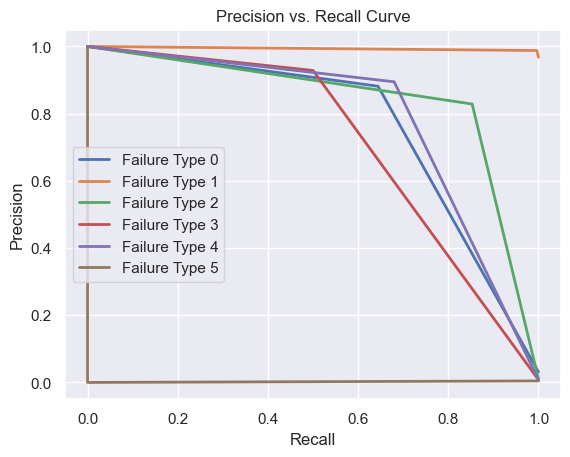

In [44]:
precision = dict()
recall = dict()
n_classes = 6
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_catb[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='Failure Type {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall Curve")
plt.show()


Classification Report for column 0:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3196
           1       0.88      0.64      0.74       104

    accuracy                           0.99      3300
   macro avg       0.94      0.82      0.87      3300
weighted avg       0.99      0.99      0.99      3300



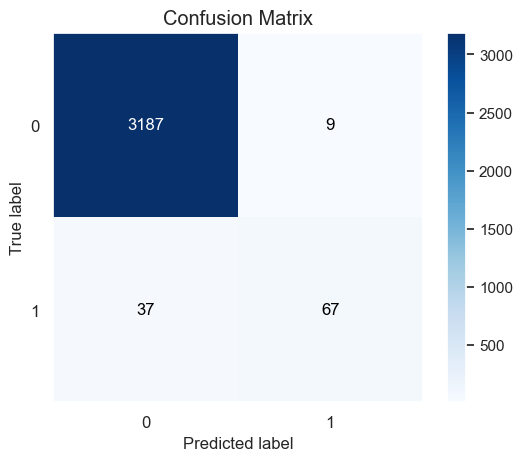

Classification Report for column 1:
               precision    recall  f1-score   support

           0       0.86      0.63      0.73       106
           1       0.99      1.00      0.99      3194

    accuracy                           0.98      3300
   macro avg       0.92      0.81      0.86      3300
weighted avg       0.98      0.98      0.98      3300



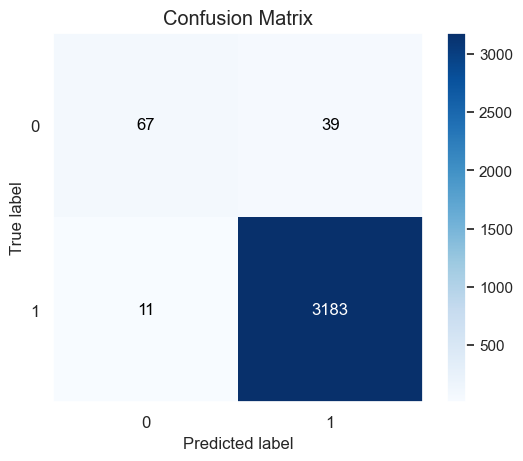

Classification Report for column 2:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3266
           1       0.83      0.85      0.84        34

    accuracy                           1.00      3300
   macro avg       0.91      0.93      0.92      3300
weighted avg       1.00      1.00      1.00      3300



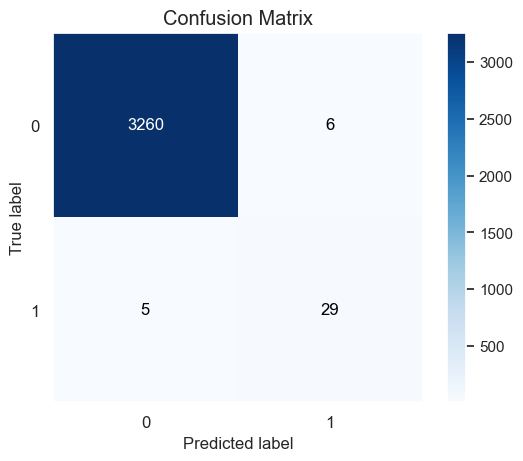

Classification Report for column 3:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3274
           1       0.93      0.50      0.65        26

    accuracy                           1.00      3300
   macro avg       0.96      0.75      0.82      3300
weighted avg       1.00      1.00      1.00      3300



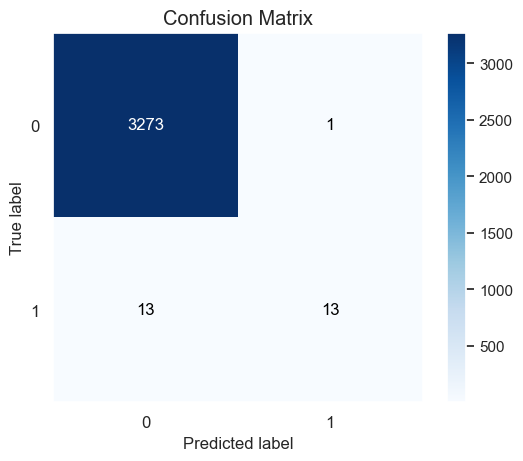

Classification Report for column 4:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3275
           1       0.89      0.68      0.77        25

    accuracy                           1.00      3300
   macro avg       0.95      0.84      0.89      3300
weighted avg       1.00      1.00      1.00      3300



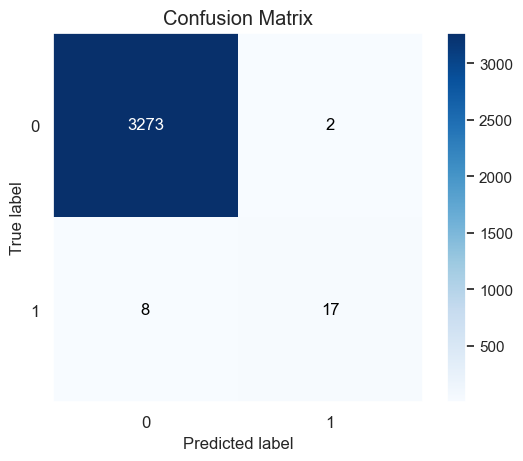

Classification Report for column 5:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3285
           1       0.00      0.00      0.00        15

    accuracy                           0.99      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       0.99      0.99      0.99      3300



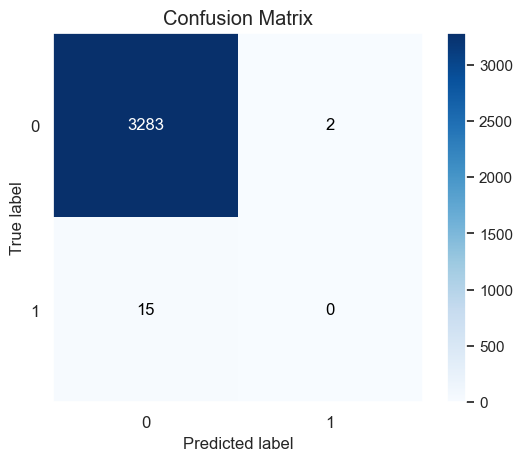

Classification Report for column 6:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3294
           1       0.00      0.00      0.00         6

    accuracy                           1.00      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       1.00      1.00      1.00      3300



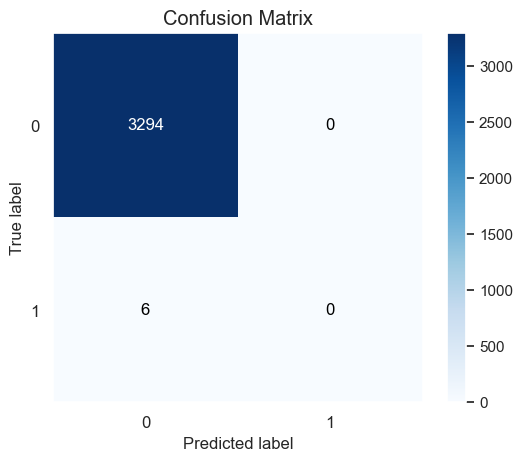

In [45]:
for i in range(y_test.shape[1]):
    print("Classification Report for column %d:\n" % i, classification_report(y_test[:, i], y_pred_catb[:, i]))
    tn, fp, fn, tp = confusion_matrix(y_test[:, i], y_pred_catb[:, i]).ravel()
    skplt.metrics.plot_confusion_matrix(y_test[:, i], y_pred_catb[:, i], normalize=False)
    plt.show()